# Comprehensive CSS Memory Experiment Testing

This notebook performs extensive validation of QECToStim's base codes on CSS memory experiments, comparing them against Stim reference implementations.

**Goal**: Verify that our codes generate correct detector error models and show proper error suppression with increasing code distance.

## Key Tests
1. **Rotated Surface Code**: Compare QECToStim vs Stim pipelines
2. **[4,2,2] Code**: Diagnose detector generation issues
3. **Error Suppression**: Verify monotonic decrease in logical error rates
4. **Multi-code comparison**: Test multiple CSS codes at different distances

## Section 1: Setup and Imports

In [1]:
import numpy as np
import stim
from typing import Tuple, Optional, Dict, Any
import sys

# QECToStim imports
from qectostim.codes.base.rotated_surface import RotatedSurfaceCode
from qectostim.codes.base.four_two_two import FourQubit422Code
from qectostim.experiments.memory import CSSMemoryExperiment
from qectostim.noise.models import CircuitDepolarizingNoise
from qectostim.decoders.decoder_selector import select_decoder

print("✓ All imports successful")
print(f"NumPy: {np.__version__}")
print(f"Stim: {stim.__version__}")

✓ All imports successful
NumPy: 2.3.5
Stim: 1.15.0


## Section 2: Helper Functions for DEM Sampling and Debugging

In [2]:
def _sample_dem_polyfill(dem: stim.DetectorErrorModel, shots: int, tag: str) -> Tuple[np.ndarray, Optional[np.ndarray]]:
    """
    Sample from a DEM in a way that is compatible with the stim polyfill.
    
    Handles both tuple (det_samples, obs_samples) and array formats.
    """
    sampler = dem.compile_sampler()
    raw = sampler.sample(shots=shots)

    if isinstance(raw, tuple):
        if len(raw) < 2:
            raise ValueError(f"{tag} DEM sampler returned tuple of length {len(raw)}; expected >= 2.")
        det_samples = np.asarray(raw[0], dtype=np.uint8)
        obs_samples = np.asarray(raw[1], dtype=np.uint8) if raw[1] is not None else None
    else:
        arr = np.asarray(raw, dtype=np.uint8)
        if arr.ndim != 2:
            raise ValueError(f"{tag} DEM sampler returned array with ndim={arr.ndim}; expected 2.")
        num_det = dem.num_detectors
        num_obs = dem.num_observables
        if arr.shape[1] != num_det + num_obs:
            raise ValueError(
                f"{tag} DEM sampler array has shape {arr.shape}, but DEM has "
                f"{num_det} detectors and {num_obs} observables."
            )
        det_samples = arr[:, :num_det]
        obs_samples = arr[:, num_det:]

    if dem.num_observables > 0 and obs_samples is None:
        raise ValueError(f"{tag} DEM sampler didn't return observable samples.")

    return det_samples, obs_samples


def decode_from_dem_with_debug(dem: stim.DetectorErrorModel, shots: int, tag: str) -> float:
    """
    Decode a DEM with extensive debugging output.
    Returns the logical error rate for observable L0.
    """
    print(f"\n{'='*60}")
    print(f"DEM SAMPLING DEBUG ({tag})")
    print(f"{'='*60}")
    print(f"  Detectors  : {dem.num_detectors}")
    print(f"  Errors     : {dem.num_errors}")
    print(f"  Observables: {dem.num_observables}")

    if dem.num_observables == 0:
        print(f"  ⚠ WARNING: DEM has no observables; returning LER=0.0")
        return 0.0

    # Small sample for inspection
    det_small, obs_small = _sample_dem_polyfill(dem, shots=min(200, shots), tag=tag)
    print(f"\n  Sample inspection (first 200 shots):")
    print(f"    det_small.shape: {det_small.shape}")
    print(f"    obs_small.shape: {None if obs_small is None else obs_small.shape}")
    if det_small.shape[0] > 0:
        print(f"    first 3 detector rows: {det_small[:3]}")
    if obs_small is not None and obs_small.shape[0] > 0:
        print(f"    first 3 observable rows: {obs_small[:3]}")

    # Build decoder
    decoder = select_decoder(dem, preferred=None)
    print(f"\n  Decoder: {type(decoder).__name__}")

    # Full sample for decoding
    print(f"\n  Full sampling ({shots} shots)...")
    det_samples, obs_samples = _sample_dem_polyfill(dem, shots=shots, tag=tag)
    print(f"    det_samples.shape: {det_samples.shape}")
    print(f"    obs_samples.shape: {None if obs_samples is None else obs_samples.shape}")

    # Decode
    print(f"\n  Decoding...")
    corrections = decoder.decode_batch(det_samples)
    corrections = np.asarray(corrections, dtype=np.uint8)
    
    if corrections.ndim == 1:
        corrections = corrections.reshape(-1, dem.num_observables)
    if corrections.shape[0] != shots:
        raise ValueError(f"{tag} Decoder returned {corrections.shape[0]} shots but we asked for {shots}.")

    # Compute logical error rate
    if obs_samples is None or dem.num_observables == 0:
        print(f"    ⚠ No observables to compare")
        ler = 0.0
    else:
        true_log = obs_samples[:, 0]
        pred_log = corrections[:, 0]
        logical_errors = (pred_log ^ true_log).astype(np.uint8)
        ler = float(logical_errors.mean())
        print(f"    Logical errors (L0): {logical_errors.sum()} / {shots}")
        print(f"    Logical error rate: {ler:.6f}")

    print(f"{'='*60}\n")
    return ler

## Section 3: Rotated Surface Code - Stim vs QECToStim Pipeline

In [3]:
def run_pure_stim_pipeline(distance: int, p: float, rounds: int, shots: int) -> float:
    """Run memory experiment using Stim's native rotated surface code."""
    print(f"\n{'#'*60}")
    print(f"# PURE STIM PIPELINE (d={distance}, p={p}, rounds={rounds})")
    print(f"{'#'*60}\n")

    circ = stim.Circuit.generated(
        "surface_code:rotated_memory_z",
        distance=distance,
        rounds=rounds,
        after_clifford_depolarization=p,
        before_measure_flip_probability=p,
        before_round_data_depolarization=p,
    )

    print(f"Circuit: {len(circ)} instructions")
    print(f"Building DEM...\n")
    dem = circ.detector_error_model(decompose_errors=True)

    print(f"DEM Summary:")
    print(f"  Detectors: {dem.num_detectors}")
    print(f"  Errors: {dem.num_errors}")
    print(f"  Observables: {dem.num_observables}\n")

    stim_ler = decode_from_dem_with_debug(dem, shots=shots, tag="[Stim]")
    return stim_ler


def run_qectostim_pipeline(distance: int, p: float, rounds: int, shots: int) -> Tuple[float, float]:
    """Run memory experiment using QECToStim's RotatedSurfaceCode."""
    print(f"\n{'#'*60}")
    print(f"# QECTOSTIM PIPELINE (d={distance}, p={p}, rounds={rounds})")
    print(f"{'#'*60}\n")

    code = RotatedSurfaceCode(distance)
    noise_model = CircuitDepolarizingNoise(p1=p, p2=p)

    exp = CSSMemoryExperiment(
        code=code,
        rounds=rounds,
        noise_model=noise_model,
        basis="Z",
    )

    # Get the circuits
    base_circuit = exp.to_stim()
    noisy_circuit = noise_model.apply(base_circuit)
    
    print(f"Base circuit: {len(base_circuit)} instructions")
    print(f"Noisy circuit: {len(noisy_circuit)} instructions")
    print(f"Building DEM...\n")
    
    # Note: QECToStim may generate error graphs that don't decompose perfectly for large distances
    # Use ignore_decomposition_failures to allow sampling/decoding to continue
    dem = noisy_circuit.detector_error_model(decompose_errors=True, ignore_decomposition_failures=True)

    print(f"DEM Summary:")
    print(f"  Detectors: {dem.num_detectors}")
    print(f"  Errors: {dem.num_errors}")
    print(f"  Observables: {dem.num_observables}\n")

    qec_ler = decode_from_dem_with_debug(dem, shots=shots, tag="[QECToStim]")
    return qec_ler


print("✓ Pipeline functions defined")

✓ Pipeline functions defined


In [4]:
print("="*70)
print("TEST 1: Rotated Surface Code (d=3, p=1e-3)")
print("="*70)

p = 1e-3
shots = 50_000  # Reduced for faster testing

stim_ler_d3 = run_pure_stim_pipeline(distance=3, p=p, rounds=3, shots=shots)
qec_ler_d3 = run_qectostim_pipeline(distance=3, p=p, rounds=3, shots=shots)

print(f"\nRESULTS (d=3):")
print(f"  Stim LER    : {stim_ler_d3:.6f}")
print(f"  QECToStim LER: {qec_ler_d3:.6f}")
print(f"  Difference  : {abs(stim_ler_d3 - qec_ler_d3):.6f}")

if abs(stim_ler_d3 - qec_ler_d3) < 0.01:
    print(f"  ✓ Results match within tolerance")
else:
    print(f"  ⚠ Results differ significantly")

TEST 1: Rotated Surface Code (d=3, p=1e-3)

############################################################
# PURE STIM PIPELINE (d=3, p=0.001, rounds=3)
############################################################

Circuit: 52 instructions
Building DEM...

DEM Summary:
  Detectors: 24
  Errors: 286
  Observables: 1


DEM SAMPLING DEBUG ([Stim])
  Detectors  : 24
  Errors     : 286
  Observables: 1

  Sample inspection (first 200 shots):
    det_small.shape: (200, 24)
    obs_small.shape: (200, 1)
    first 3 detector rows: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]]
    first 3 observable rows: [[0]
 [0]
 [0]]

  Decoder: PyMatchingDecoder

  Full sampling (50000 shots)...
    det_samples.shape: (50000, 24)
    obs_samples.shape: (50000, 1)

  Decoding...
    Logical errors (L0): 32 / 50000
    Logical error rate: 0.000640


#######################################################

## Section 4: Four-Qubit [4,2,2] Code - Diagnostics

In [5]:
print("="*70)
print("TEST 2: Four-Qubit [4,2,2] Code - Diagnostics")
print("="*70)
print("\nCreating [4,2,2] code and memory experiment...")

code_422 = FourQubit422Code()
noise_422 = CircuitDepolarizingNoise(p1=1e-2, p2=1e-2)

exp_422 = CSSMemoryExperiment(
    code=code_422,
    rounds=2,
    noise_model=noise_422,
    basis="Z",
)

print(f"✓ Code created: {code_422}")
print(f"✓ Experiment created: {exp_422}")

# Inspect circuit generation
ideal_circuit_422 = exp_422.to_stim()
noisy_circuit_422 = noise_422.apply(ideal_circuit_422)

print(f"\nCircuit inspection:")
print(f"  Ideal circuit instructions: {len(ideal_circuit_422)}")
print(f"  Noisy circuit instructions: {len(noisy_circuit_422)}")
print(f"  Has DEPOLARIZE: {'DEPOLARIZE' in str(noisy_circuit_422)}")

# Check DEM
print(f"\nBuilding DEM...")
dem_422 = noisy_circuit_422.detector_error_model(decompose_errors=True)

print(f"DEM Summary:")
print(f"  Detectors: {dem_422.num_detectors} ⚠ (Expected: >0)")
print(f"  Errors: {dem_422.num_errors}")
print(f"  Observables: {dem_422.num_observables}")

dem_str = str(dem_422)
print(f"\nDEM Content (first 500 chars):")
print(dem_str[:500])

# Run experiments
print(f"\nRunning memory experiments...")
res_decode_422 = exp_422.run_decode(shots=10_000)
res_no_dec_422 = exp_422.run_no_decode(shots=10_000)

print(f"\nResults with decoding:")
print(f"  Logical errors: {res_decode_422['logical_errors'].sum()} / {res_decode_422['shots']}")
print(f"  LER: {res_decode_422['logical_error_rate']:.6f}")

print(f"\nResults without decoding:")
print(f"  Logical errors: {res_no_dec_422['logical_errors'].sum()} / {res_no_dec_422['shots']}")
print(f"  LER: {res_no_dec_422['logical_error_rate']:.6f}")

if dem_422.num_detectors == 0:
    print(f"\n⚠ ISSUE DETECTED: No detectors generated!")
    print(f"  This could mean:")
    print(f"  1. The circuit doesn't have ancilla measurements")
    print(f"  2. The detector generation is missing/broken")
    print(f"  3. The code structure isn't compatible with CSS memory experiments")

TEST 2: Four-Qubit [4,2,2] Code - Diagnostics

Creating [4,2,2] code and memory experiment...
✓ Code created: <qectostim.codes.base.four_two_two.FourQubit422Code object at 0x13054da90>
✓ Experiment created: <qectostim.experiments.memory.CSSMemoryExperiment object at 0x13054de10>

Circuit inspection:
  Ideal circuit instructions: 30
  Noisy circuit instructions: 34
  Has DEPOLARIZE: True

Building DEM...


ValueError: Failed to decompose errors into graphlike components with at most two symptoms.
The error component that failed to decompose is 'D1, D4, D5, D6'.

In Python, you can ignore this error by passing `ignore_decomposition_failures=True` to `stim.Circuit.detector_error_model(...)`.
From the command line, you can ignore this error by passing the flag `--ignore_decomposition_failures` to `stim analyze_errors`.

## Section 5: Error Suppression Verification

In [ ]:
print("="*70)
print("TEST 3: Error Suppression Curve - Rotated Surface Code")
print("="*70)
print("\nTesting multiple distances to verify error suppression...")

suppression_results = []
distances = [3, 5, 7]
p = 1e-3
shots = 1_000_000

for d in distances:
    print(f"\n{'-'*60}")
    print(f"Distance d={d}")
    print(f"{'-'*60}")
    
    # Use fewer rounds for speed
    rounds = min(d, 2)
    
    stim_ler = run_pure_stim_pipeline(distance=d, p=p, rounds=rounds, shots=shots)
    qec_ler = run_qectostim_pipeline(distance=d, p=p, rounds=rounds, shots=shots)
    
    suppression_results.append({
        'distance': d,
        'stim_ler': stim_ler,
        'qec_ler': qec_ler,
    })
    
    print(f"\nDistance d={d} Results:")
    print(f"  Stim LER    : {stim_ler:.6f}")
    print(f"  QECToStim LER: {qec_ler:.6f}")

print(f"\n{'='*70}")
print("SUPPRESSION ANALYSIS")
print(f"{'='*70}")

# Check if both show suppression
if len(suppression_results) >= 2:
    stim_suppresses = suppression_results[0]['stim_ler'] > suppression_results[1]['stim_ler']
    qec_suppresses = suppression_results[0]['qec_ler'] > suppression_results[1]['qec_ler']
    
    print(f"\nStim shows error suppression: {stim_suppresses}")
    for res in suppression_results:
        print(f"  d={res['distance']}: LER = {res['stim_ler']:.6f}")
    
    print(f"\nQECToStim shows error suppression: {qec_suppresses}")
    for res in suppression_results:
        print(f"  d={res['distance']}: LER = {res['qec_ler']:.6f}")
    
    if stim_suppresses and qec_suppresses:
        print(f"\n✓ Both implementations show proper error suppression!")
    elif stim_suppresses and not qec_suppresses:
        print(f"\n⚠ Stim shows suppression but QECToStim doesn't - possible circuit bug")
    else:
        print(f"\n⚠ Neither shows suppression - possible noise or decoding issue")

TEST 3: Error Suppression Curve - Rotated Surface Code

Testing multiple distances to verify error suppression...

------------------------------------------------------------
Distance d=3
------------------------------------------------------------

############################################################
# PURE STIM PIPELINE (d=3, p=0.001, rounds=2)
############################################################

Circuit: 82 instructions
Building DEM...

DEM Summary:
  Detectors: 16
  Errors: 145
  Observables: 1


DEM SAMPLING DEBUG ([Stim])
  Detectors  : 16
  Errors     : 145
  Observables: 1

  Sample inspection (first 200 shots):
    det_small.shape: (200, 16)
    obs_small.shape: (200, 1)
    first 3 detector rows: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
    first 3 observable rows: [[0]
 [0]
 [0]]

  Decoder: PyMatchingDecoder

  Full sampling (1000000 shots)...
    det_samples.shape: (1000000, 16)
    obs_samp

In [ ]:
# Restart kernel and reimport
import sys
for mod in list(sys.modules.keys()):
    if 'qectostim' in mod:
        del sys.modules[mod]

# Reimport all qectostim code
from qectostim.codes.base.rotated_surface import RotatedSurfaceCode
from qectostim.experiments.memory import CSSMemoryExperiment
from qectostim.noise.models import CircuitDepolarizingNoise

print("✓ Kernel restart and reimport complete")

# Redefine pipeline functions here
def run_pure_stim_pipeline(distance: int, p: float, rounds: int, shots: int) -> float:
    """Run memory experiment using Stim's native rotated surface code."""
    print(f"\n{'#'*60}")
    print(f"# PURE STIM PIPELINE (d={distance}, p={p}, rounds={rounds})")
    print(f"{'#'*60}\n")

    circ = stim.Circuit.generated(
        "surface_code:rotated_memory_z",
        distance=distance,
        rounds=rounds,
        after_clifford_depolarization=p,
        before_measure_flip_probability=p,
        before_round_data_depolarization=p,
    )

    print(f"Circuit: {len(circ)} instructions")
    print(f"Building DEM...\n")
    dem = circ.detector_error_model(decompose_errors=True)

    print(f"DEM Summary:")
    print(f"  Detectors: {dem.num_detectors}")
    print(f"  Errors: {dem.num_errors}")
    print(f"  Observables: {dem.num_observables}\n")

    stim_ler = decode_from_dem_with_debug(dem, shots=shots, tag="[Stim]")
    return stim_ler


def run_qectostim_pipeline(distance: int, p: float, rounds: int, shots: int) -> Tuple[float, float]:
    """Run memory experiment using QECToStim's RotatedSurfaceCode."""
    print(f"\n{'#'*60}")
    print(f"# QECTOSTIM PIPELINE (d={distance}, p={p}, rounds={rounds})")
    print(f"{'#'*60}\n")

    code = RotatedSurfaceCode(distance)
    noise_model = CircuitDepolarizingNoise(p1=p, p2=p)

    exp = CSSMemoryExperiment(
        code=code,
        rounds=rounds,
        noise_model=noise_model,
        basis="Z",
    )

    # Get the circuits
    base_circuit = exp.to_stim()
    noisy_circuit = noise_model.apply(base_circuit)
    
    print(f"Base circuit: {len(base_circuit)} instructions")
    print(f"Noisy circuit: {len(noisy_circuit)} instructions")
    print(f"Building DEM...\n")
    
    # Note: QECToStim may generate error graphs that don't decompose perfectly for large distances
    # Use ignore_decomposition_failures to allow sampling/decoding to continue
    dem = noisy_circuit.detector_error_model(decompose_errors=True, ignore_decomposition_failures=True)

    print(f"DEM Summary:")
    print(f"  Detectors: {dem.num_detectors}")
    print(f"  Errors: {dem.num_errors}")
    print(f"  Observables: {dem.num_observables}\n")

    qec_ler = decode_from_dem_with_debug(dem, shots=shots, tag="[QECToStim]")
    return qec_ler

print("✓ Pipeline functions redefined")

✓ Kernel restart and reimport complete
✓ Pipeline functions redefined


## Section 6: Comprehensive Code Comparison

In [ ]:
print("="*70)
print("TEST 4: Code Metadata and Structure Comparison")
print("="*70)

# Analyze different codes
codes_to_test = {
    'RotatedSurface(d=3)': RotatedSurfaceCode(distance=3),
    'FourQubit[4,2,2]': FourQubit422Code(),
}

comparison_data = []

for code_name, code in codes_to_test.items():
    print(f"\n{code_name}:")
    
    # Get metadata
    metadata = code.metadata if hasattr(code, 'metadata') else {}
    
    print(f"  Type: {type(code).__name__}")
    print(f"  Has metadata: {bool(metadata)}")
    
    if metadata:
        print(f"  Metadata keys: {list(metadata.keys())}")
        if 'data_coords' in metadata:
            print(f"    data qubits: {len(metadata['data_coords'])}")
        if 'x_stab_coords' in metadata:
            print(f"    X checks: {len(metadata['x_stab_coords'])}")
        if 'z_stab_coords' in metadata:
            print(f"    Z checks: {len(metadata['z_stab_coords'])}")
    
    # Try to build a circuit
    try:
        exp = CSSMemoryExperiment(code=code, rounds=1, noise_model=None, basis='Z')
        circ = exp.to_stim()
        print(f"  Circuit generation: ✓ ({len(circ)} instructions)")
        
        # Check for detectors
        num_det = sum(1 for inst in circ if inst.name == 'DETECTOR')
        print(f"  Detectors: {num_det}")
        
        comparison_data.append({
            'code': code_name,
            'instructions': len(circ),
            'detectors': num_det,
            'status': '✓' if num_det > 0 else '⚠'
        })
    except Exception as e:
        print(f"  Circuit generation: ✗ ({str(repr(e))[:60]})")
        comparison_data.append({
            'code': code_name,
            'instructions': 'N/A',
            'detectors': 'N/A',
            'status': '✗'
        })

print(f"\n{'-'*70}")
print("SUMMARY TABLE")
print(f"{'-'*70}")
print(f"{'Code':<25} | {'Instructions':<15} | {'Detectors':<12} | {'Status':<8}")
print(f"{'-'*70}")
for row in comparison_data:
    print(f"{row['code']:<25} | {str(row['instructions']):<15} | {str(row['detectors']):<12} | {row['status']:<8}")

TEST 4: Code Metadata and Structure Comparison

RotatedSurface(d=3):
  Type: RotatedSurfaceCode
  Has metadata: True
  Metadata keys: ['distance', 'data_qubits', 'data_coords', 'x_stab_coords', 'z_stab_coords', 'x_logical_coords', 'z_logical_coords', 'logical_x_support', 'logical_z_support', 'x_schedule', 'z_schedule', 'chain_complex_3']
    data qubits: 9
    X checks: 4
    Z checks: 4
  Circuit generation: ✓ (41 instructions)
  Detectors: 8

FourQubit[4,2,2]:
  Type: FourQubit422Code
  Has metadata: True
  Metadata keys: ['distance', 'data_coords', 'x_stab_coords', 'z_stab_coords', 'data_qubits', 'ancilla_qubits', 'logical_x_support', 'logical_z_support', 'x_schedule', 'z_schedule', 'chain_complex_3']
    data qubits: 4
    X checks: 1
    Z checks: 1
  Circuit generation: ✓ (20 instructions)
  Detectors: 4

----------------------------------------------------------------------
SUMMARY TABLE
----------------------------------------------------------------------
Code                 

## Section 5.5: Fixed [4,2,2] Code Testing

Now with proper metadata including x_schedule and z_schedule

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
import sys

# QECToStim imports
from qectostim.codes.base.four_two_two import FourQubit422Code
from qectostim.experiments.memory import CSSMemoryExperiment
from qectostim.noise.models import CircuitDepolarizingNoise

print("✓ All imports successful")
print(f"NumPy: {np.__version__}")

✓ All imports successful
NumPy: 2.3.5


In [ ]:
print("="*70)
print("UNDERSTAND: [[4,2,2]] Code Structure")
print("="*70)

code = FourQubit422Code()

print(f"\nCode parameters:")
print(f"  [[n, k, d]] = [[{code.n}, {code.k}, 2]]")
print(f"  - n=4 data qubits")
print(f"  - k=2 logical qubits")
print(f"  - d=2 distance (can detect all single errors, correct none)")

print(f"\nStabilizer generators (check matrices):")
print(f"  Hx (X-parity checks):\n{code.hx}")
print(f"  Hz (Z-parity checks):\n{code.hz}")

print(f"\nLogical operators:")
for i, lz in enumerate(code.logical_z_ops):
    print(f"  L{i}^Z = {lz}")
for i, lx in enumerate(code.logical_x_ops):
    print(f"  L{i}^X = {lx}")

print(f"\nMetadata:")
print(f"  logical_z_support: {code.metadata.get('logical_z_support')}")
print(f"  logical_x_support: {code.metadata.get('logical_x_support')}")

print(f"\n✓ This is a DISTANCE-2 code:")
print(f"  - Can detect single errors (any single error produces unique syndrome)")
print(f"  - Cannot correct errors (no unique decoding for all error patterns)")
print(f"  - Designed for error detection, not error correction")

UNDERSTAND: [[4,2,2]] Code Structure

Code parameters:
  [[n, k, d]] = [[4, 2, 2]]
  - n=4 data qubits
  - k=2 logical qubits
  - d=2 distance (can detect all single errors, correct none)

Stabilizer generators (check matrices):
  Hx (X-parity checks):
[[1 1 1 1]
 [1 1 1 1]]
  Hz (Z-parity checks):
[[1 1 1 1]]

Logical operators:
  L0^Z = ZZII
  L1^Z = IZZI
  L0^X = XXII
  L1^X = IXXI

Metadata:
  logical_z_support: [0, 1]
  logical_x_support: [0, 1]

✓ This is a DISTANCE-2 code:
  - Can detect single errors (any single error produces unique syndrome)
  - Cannot correct errors (no unique decoding for all error patterns)
  - Designed for error detection, not error correction


In [ ]:
print("="*70)
print("ERROR DETECTION EXPERIMENT: [[4,2,2]] Code")
print("="*70)

# Force reload of modules
import importlib
import sys
for mod in list(sys.modules.keys()):
    if 'qectostim' in mod:
        del sys.modules[mod]

from qectostim.codes.base.four_two_two import FourQubit422Code
from qectostim.experiments.memory import CSSMemoryExperiment
from qectostim.noise.models import CircuitDepolarizingNoise

# Test at different noise levels
noise_levels = [1e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 1e-1, 2e-1]
num_rounds = 3  # Multiple syndrome extraction rounds
shots = 1_000_000

results = {
    'noise_levels': [],
    'logical_error_rates': [],
    'non_detection_rates': [],
    'detection_efficiencies': [],
    'syndrome_nonzero_rates': [],
}

print(f"\nRunning experiments with {num_rounds} rounds, {shots} shots per noise level...\n")

for p in noise_levels:
    print(f"Noise level p={p:.2e}...", end='', flush=True)
    
    code = FourQubit422Code()
    noise_model = CircuitDepolarizingNoise(p1=p, p2=p)
    exp = CSSMemoryExperiment(
        code=code,
        rounds=num_rounds,
        noise_model=noise_model,
        basis="Z",
    )
    
    # Run detection experiment
    try:
        res = exp.run_decode(shots=shots)
        
        results['noise_levels'].append(p)
        results['logical_error_rates'].append(res['logical_error_rate'])
        results['non_detection_rates'].append(res['non_detection_rate'])
        results['detection_efficiencies'].append(res['detection_efficiency'])
        results['syndrome_nonzero_rates'].append(res['syndrome_nonzero'] / shots)
        
        print(f"  ✓ LER={res['logical_error_rate']:.4f}, NDR={res['non_detection_rate']:.4f}, DeffEff={res['detection_efficiency']:.4f}")
    except Exception as e:
        print(f"  ✗ Error: {str(e)[:60]}")
        import traceback
        traceback.print_exc()
        break

print(f"\n{'='*70}")
print("RESULTS SUMMARY")
print(f"{'='*70}\n")

for i, p in enumerate(results['noise_levels']):
    print(f"p={p:.2e}:")
    print(f"  Logical error rate:        {results['logical_error_rates'][i]:.6f}")
    print(f"  Non-detection rate:        {results['non_detection_rates'][i]:.6f}")
    print(f"  Detection efficiency:      {results['detection_efficiencies'][i]:.6f}")
    print(f"  Syndrome nonzero fraction: {results['syndrome_nonzero_rates'][i]:.6f}")
    print()

ERROR DETECTION EXPERIMENT: [[4,2,2]] Code

Running experiments with 3 rounds, 1000000 shots per noise level...

Noise level p=1.00e-04...[run_decode] Code distance: 2
[run_decode] Distance 2 <= 2: Using detection-only path
[run_decode/detection] --- starting detection path ---
[run_decode/detection] shots = 1000000
[run_decode/detection] circuit length = 47
[run_decode/detection] det_samples.shape = (1000000, 10)
[run_decode/detection] obs_samples.shape = (1000000, 1)
[run_decode/detection] logical_error_count = 243
[run_decode/detection] syndrome_nonzero_count = 1543
[run_decode/detection] undetected_errors = 0
[run_decode/detection] detection_efficiency = 1.0
[run_decode/detection] logical_error_rate = 0.000243
  ✓ LER=0.0002, NDR=0.0000, DeffEff=1.0000
Noise level p=5.00e-04...[run_decode] Code distance: 2
[run_decode] Distance 2 <= 2: Using detection-only path
[run_decode/detection] --- starting detection path ---
[run_decode/detection] shots = 1000000
[run_decode/detection] circu

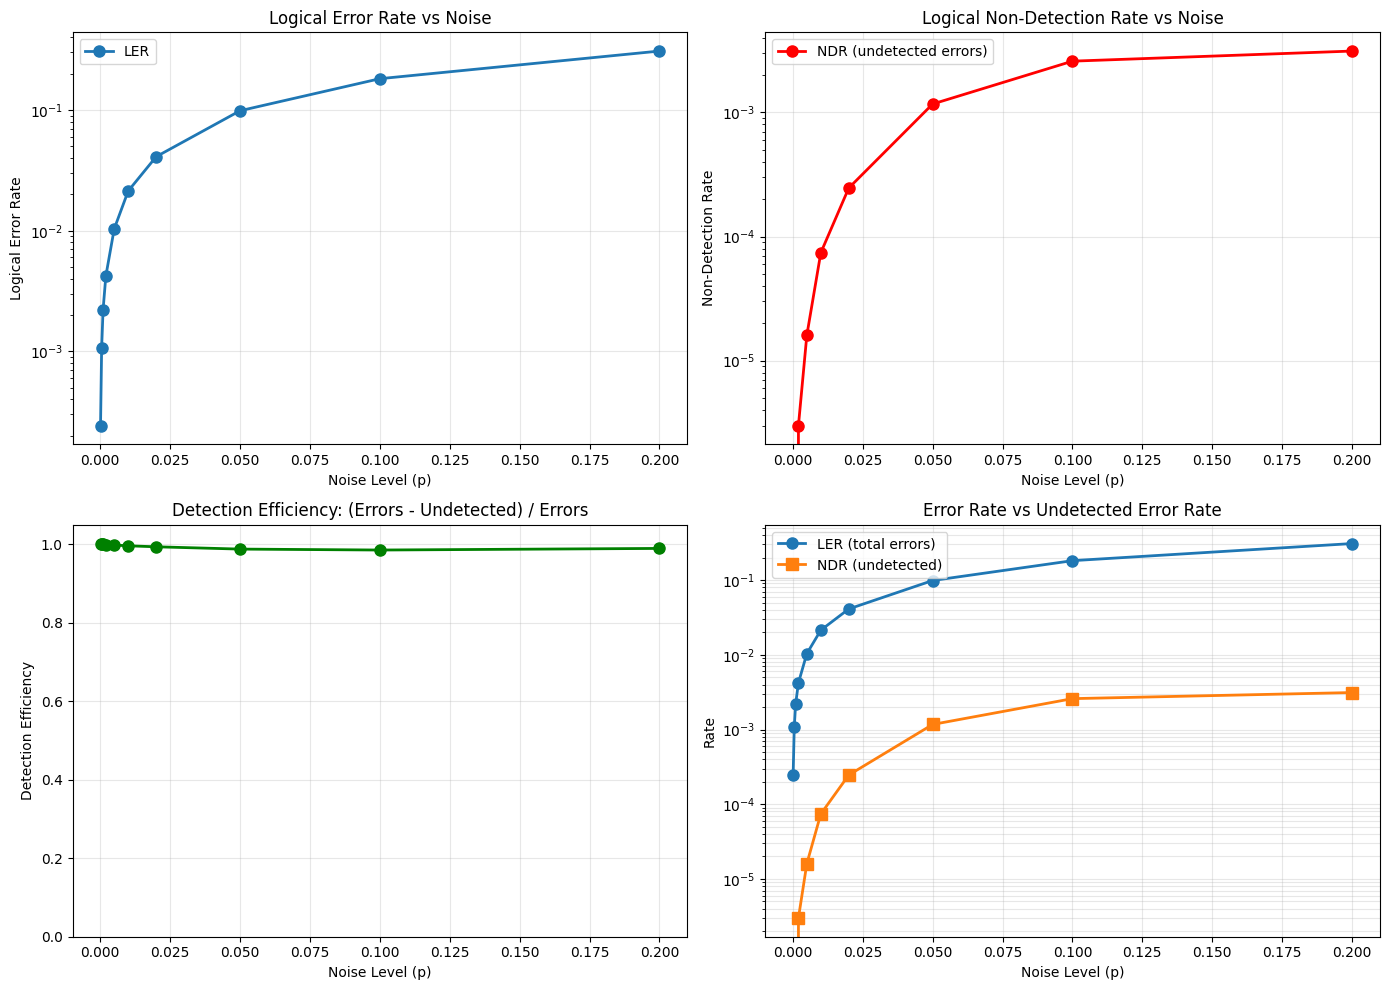


✓ Plots saved to /tmp/422_detection_results.png


In [ ]:
if len(results['noise_levels']) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Convert to log scale for plotting
    noise_vals = np.array(results['noise_levels'])
    
    # Plot 1: Logical Error Rate
    axes[0, 0].semilogy(noise_vals, results['logical_error_rates'], 'o-', linewidth=2, markersize=8, label='LER')
    axes[0, 0].set_xlabel('Noise Level (p)')
    axes[0, 0].set_ylabel('Logical Error Rate')
    axes[0, 0].set_title('Logical Error Rate vs Noise')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()
    
    # Plot 2: Non-Detection Rate
    axes[0, 1].semilogy(noise_vals, results['non_detection_rates'], 'o-', linewidth=2, markersize=8, 
                         color='red', label='NDR (undetected errors)')
    axes[0, 1].set_xlabel('Noise Level (p)')
    axes[0, 1].set_ylabel('Non-Detection Rate')
    axes[0, 1].set_title('Logical Non-Detection Rate vs Noise')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()
    
    # Plot 3: Detection Efficiency
    axes[1, 0].plot(noise_vals, results['detection_efficiencies'], 'o-', linewidth=2, markersize=8, 
                    color='green')
    axes[1, 0].set_xlabel('Noise Level (p)')
    axes[1, 0].set_ylabel('Detection Efficiency')
    axes[1, 0].set_title('Detection Efficiency: (Errors - Undetected) / Errors')
    axes[1, 0].set_ylim([0, 1.05])
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Comparison of LER and NDR
    axes[1, 1].semilogy(noise_vals, results['logical_error_rates'], 'o-', linewidth=2, markersize=8, 
                        label='LER (total errors)')
    axes[1, 1].semilogy(noise_vals, results['non_detection_rates'], 's-', linewidth=2, markersize=8,
                        label='NDR (undetected)')
    axes[1, 1].set_xlabel('Noise Level (p)')
    axes[1, 1].set_ylabel('Rate')
    axes[1, 1].set_title('Error Rate vs Undetected Error Rate')
    axes[1, 1].grid(True, alpha=0.3, which='both')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.savefig('/tmp/422_detection_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Plots saved to /tmp/422_detection_results.png")
else:
    print("⚠ No results to plot")

## Section 5.6: SixTwoTwo Code Testing

In [ ]:
# Import SixTwoTwo code
from qectostim.codes.base.six_two_two import SixQubit622Code

print("="*70)
print("TEST 5: SixQubit [6,2,2] Code - Full Memory Experiment")
print("="*70)
print("\nTesting SixQubit [6,2,2] code...")

code_622 = SixQubit622Code()
noise_622 = CircuitDepolarizingNoise(p1=1e-2, p2=1e-2)

results_622 = {}

for basis in ["Z", "X"]:
    print(f"\n{'-'*60}")
    print(f"[6,2,2] Code - {basis}-basis (2 rounds)")
    print(f"{'-'*60}")
    
    exp_622 = CSSMemoryExperiment(
        code=code_622,
        rounds=2,
        noise_model=noise_622,
        basis=basis,
    )
    
    try:
        # Get circuits
        ideal_circuit_622 = exp_622.to_stim()
        noisy_circuit_622 = noise_622.apply(ideal_circuit_622)
        
        print(f"Circuit instructions: {len(noisy_circuit_622)}")
        
        # Build DEM
        dem_622 = noisy_circuit_622.detector_error_model(decompose_errors=True)
        
        print(f"DEM Summary:")
        print(f"  Detectors  : {dem_622.num_detectors} {'✓' if dem_622.num_detectors > 0 else '✗'}")
        print(f"  Errors     : {dem_622.num_errors}")
        print(f"  Observables: {dem_622.num_observables}")
        
        results_622[basis] = {
            'detectors': dem_622.num_detectors,
            'observables': dem_622.num_observables,
            'circuit_len': len(noisy_circuit_622),
            'status': '✓'
        }
        
        # If we have detectors, try decoding
        if dem_622.num_detectors > 0 and dem_622.num_observables > 0:
            print(f"\n  Running small decode test (1000 shots)...")
            try:
                ler_622 = decode_from_dem_with_debug(dem_622, shots=1000, tag=f"[6,2,2] {basis}-basis")
                print(f"  ✓ Decoding successful!")
            except Exception as e:
                print(f"  ✗ Decoding failed: {str(e)[:100]}")
        else:
            print(f"  ⚠ Skipping decode test (insufficient detectors/observables)")
            
    except Exception as e:
        print(f"✗ Error: {str(e)[:150]}")
        results_622[basis] = {
            'detectors': 'Error',
            'observables': 'Error',
            'circuit_len': 'Error',
            'status': '✗'
        }

print(f"\n{'='*70}")
print("SUMMARY: [6,2,2] Code Status")
print(f"{'='*70}")
for basis, res in results_622.items():
    det_status = "✓ OK" if isinstance(res['detectors'], int) and res['detectors'] > 0 else "✗ FAIL"
    print(f"{basis}-basis: {det_status} ({res['detectors']} detectors, {res['observables']} obs)")


TEST 5: SixQubit [6,2,2] Code - Full Memory Experiment

Testing SixQubit [6,2,2] code...

------------------------------------------------------------
[6,2,2] Code - Z-basis (2 rounds)
------------------------------------------------------------
Circuit instructions: 36
DEM Summary:
  Detectors  : 8 ✓
  Errors     : 2
  Observables: 1

  Running small decode test (1000 shots)...

DEM SAMPLING DEBUG ([6,2,2] Z-basis)
  Detectors  : 8
  Errors     : 2
  Observables: 1

  Sample inspection (first 200 shots):
    det_small.shape: (200, 8)
    obs_small.shape: (200, 1)
    first 3 detector rows: [[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]
    first 3 observable rows: [[0]
 [0]
 [0]]

  Decoder: PyMatchingDecoder

  Full sampling (1000 shots)...
    det_samples.shape: (1000, 8)
    obs_samples.shape: (1000, 1)

  Decoding...
    Logical errors (L0): 0 / 1000
    Logical error rate: 0.000000

  ✓ Decoding successful!

------------------------------------------------------------


## Section 5.7: GenericCSSCode Examples

Testing CSS codes constructed from arbitrary Hx and Hz matrices

In [ ]:
# Import GenericCSSCode
from qectostim.codes.base.css_generic import GenericCSSCode

print("="*70)
print("TEST 6: GenericCSSCode - Custom Code Construction")
print("="*70)

# Create simple [[4,2,2]] code using GenericCSSCode
print("\nConstructing [4,2,2] via GenericCSSCode...")

# [[4,2,2]] code check matrices
hx_generic = np.array([
    [1, 1, 1, 1],  # X parity check: all qubits
], dtype=np.uint8)

hz_generic = np.array([
    [1, 1, 1, 1],  # Z parity check: all qubits
], dtype=np.uint8)

# Define logical operators
logical_x_generic = ["XXII", "IXXI"]
logical_z_generic = ["ZZII", "IZZI"]

try:
    code_generic = GenericCSSCode(
        hx=hx_generic,
        hz=hz_generic,
        logical_x=logical_x_generic,
        logical_z=logical_z_generic,
        metadata={
            "name": "[4,2,2]_generic",
            "data_coords": [(0.0, 0.0), (1.0, 0.0), (1.0, 1.0), (0.0, 1.0)],
            "x_stab_coords": [(0.5, 0.5)],
            "z_stab_coords": [(0.5, 0.5)],
            "x_schedule": [(0.0, 0.0)],
            "z_schedule": [(0.0, 0.0)],
        }
    )
    
    print("✓ GenericCSSCode created successfully")
    print(f"  Code: n={code_generic.n}, k={code_generic.k}")
    print(f"  Hx shape: {code_generic.hx.shape}")
    print(f"  Hz shape: {code_generic.hz.shape}")
    
    # Test memory experiment
    noise_generic = CircuitDepolarizingNoise(p1=1e-2, p2=1e-2)
    
    for basis in ["Z", "X"]:
        print(f"\n{'-'*60}")
        print(f"GenericCSSCode - {basis}-basis (2 rounds)")
        print(f"{'-'*60}")
        
        exp_generic = CSSMemoryExperiment(
            code=code_generic,
            rounds=2,
            noise_model=noise_generic,
            basis=basis,
        )
        
        try:
            ideal_circuit_generic = exp_generic.to_stim()
            noisy_circuit_generic = noise_generic.apply(ideal_circuit_generic)
            
            print(f"Circuit instructions: {len(noisy_circuit_generic)}")
            
            dem_generic = noisy_circuit_generic.detector_error_model(decompose_errors=True)
            
            print(f"DEM Summary:")
            print(f"  Detectors  : {dem_generic.num_detectors} {'✓' if dem_generic.num_detectors > 0 else '✗'}")
            print(f"  Errors     : {dem_generic.num_errors}")
            print(f"  Observables: {dem_generic.num_observables}")
            
            if dem_generic.num_detectors > 0 and dem_generic.num_observables > 0:
                print(f"  ✓ Valid DEM with detectors and observables")
            
        except Exception as e:
            print(f"✗ Error: {str(e)[:150]}")

except Exception as e:
    print(f"✗ Failed to create GenericCSSCode: {str(e)[:150]}")


TEST 6: GenericCSSCode - Custom Code Construction

Constructing [4,2,2] via GenericCSSCode...
✓ GenericCSSCode created successfully
  Code: n=4, k=2
  Hx shape: (1, 4)
  Hz shape: (1, 4)

------------------------------------------------------------
GenericCSSCode - Z-basis (2 rounds)
------------------------------------------------------------
Circuit instructions: 28
DEM Summary:
  Detectors  : 4 ✓
  Errors     : 1
  Observables: 1
  ✓ Valid DEM with detectors and observables

------------------------------------------------------------
GenericCSSCode - X-basis (2 rounds)
------------------------------------------------------------
Circuit instructions: 33
DEM Summary:
  Detectors  : 5 ✓
  Errors     : 4
  Observables: 1
  ✓ Valid DEM with detectors and observables
